In [1]:
%matplotlib inline

user-defined LaTeX commands
$\newcommand{\Er}{\mathcal{E}}$
$\newcommand{\Xset}{\mathcal{X}}$
$\newcommand{\Yset}{\mathcal{Y}}$
$\newcommand{\L}{\mathcal{L}}$
$\newcommand{\l}{\mathcal{l}}$
$\newcommand{\pr}{\mathbb{P}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\D}{\mathbb{D}}$
$\newcommand{\w}{\mathbf{w}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\J}{\mathbf{J}}$
$\newcommand{\I}{\mathbf{I}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\S}{\mathbf{S}}$
$\newcommand{\e}{\mathbf{e}}$
$\newcommand{\C}{\mathbf{C}}$
$\newcommand{\K}{\mathbf{K}}$
$\newcommand{\R}{\mathbf{R}}$
$\newcommand{\v}{\mathbf{v}}$
$\newcommand{\phivec}{\boldsymbol{\phi}}$
$\newcommand{\sign}{\mathrm{sign}}$
$\newcommand{\z}{\mathbf{z}}$
$\newcommand{\Y}{\mathbf{Y}}$
$\newcommand{\Z}{\mathbf{Z}}$
$\newcommand{\a}{\mathbf{a}}$
$\newcommand{\W}{\mathbf{W}}$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from ggplot import *

In [4]:
from matplotlib import colors as clrs
from matplotlib.colors import ListedColormap

In [5]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.stats import laplace

In [7]:
from sklearn.metrics.pairwise import check_pairwise_arrays
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import mahalanobis

In [8]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)#[:,0]
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.xlim(xx2.min(), xx2.max())
    # plot samples
    X_test, y_test = X[test_idx,:], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
    # test samples highlight
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', alpha=1.0, linewidth=1, marker='o', s=55, label='test set')

### K-Means clustering with Eulclidean distance
Let $\{\x_i\}_{i=1}^n$ - set of observations. Encoder function: $C(i)=j$, $i=1,2,\ldots,n$, and $j=1,2,\ldots,K$

Cost function: $J(C)=\frac{1}{2}\sum_{j=1}^K\sum_{C(i)=j}\sum_{C(i^{\prime})=j}\|\x_i-\x_{i^{\prime}}\|^2$

Define: $\hat{\mu}_j$, $j=1,2,\ldots,K$ - estimated maen vector for the $j$ cluster.

Simplified expression for the cost function:
$\displaystyle{J(C)=\sum_{j=1}^K\sum_{C(i)=j}\|\x_i-\hat{\mu}_j\|^2}$

**Step 1. ** For a given encoder function $C$ perform minimization: 
$\displaystyle{\underset{\{\hat{\mu}_j\}_{j=1}^K}{\min}\sum_{j=1}^K\sum_{C(i)=j}\|\x_i-\hat{\mu}_j\|^2}$

**Step 2.** For optimized cluster means $\{\hat{\mu}_j\}_{j=1}^K$ optimize encoder:
$\displaystyle{C(i)=\underset{1\leq j \leq K}{\mathrm{argmin}}\|\x_i-\hat{\mu}_j\|^2}$

In [43]:
class KMeans(object):

    def __init__(self, n_components = 2, epsilon=0.01):
        self.n_components = n_components
        self.mu =[]
        self.epsilon = epsilon

    def _get_random_point(self, X):
        return X[np.random.choice (X.shape[0], 1)[0]]

    def get_cluster_means(self, X, y):
        labs = np.arange (self.n_components)
        mu =[np.mean(X[np.where(y == lab)], axis = 0) if np.array(np.where(y == lab)).size > 0 else self._get_random_point(X) for lab in labs]
        return mu

    def update_encoder(self, X, mu):
        self.y = [np.argmin(euclidean_distances(x.reshape(1, -1), mu)) for x in X]
        return self.y
    
    def fit(self, X, y=None, n_iter=10):
        n = X.shape[0]
        labs = np.arange (self.n_components)
        self.y = np.random.choice(self.n_components, n)
        self.cost = []
        trace = []
        for i in range(n_iter):
            self.share = np.array([np.array(np.where(self.y == lab)).size for lab in labs])
            mu = self.get_cluster_means(X, self.y)
            trace.append(mu)
            self.cost.append(np.sum([(euclidean_distances(x.reshape(1, -1), mu)).min() for x in X]))
            self.y = self.update_encoder(X, mu)
            if i > 1 and np.abs(self.cost[-1] - self.cost[-2]) < self.epsilon:
                break;
        self.y = np.array(self.y)
        self.mu = mu
        self.trace = np.array(trace)
        return self

    def predict(self, X):
        return np.array (self.update_encoder (X, self.mu))

### Toy data for clusterization

In [44]:
n_centers = 5

In [45]:
X, y = make_blobs(n_samples=1000, centers=n_centers, cluster_std=1.5)

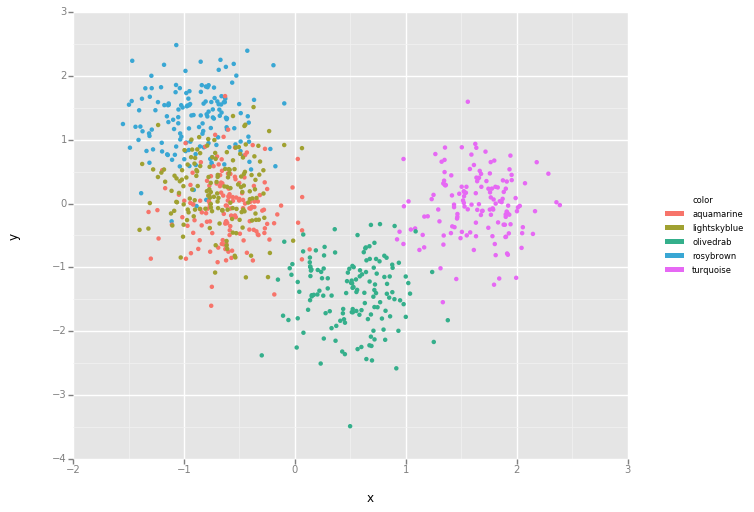

<ggplot: (293767814)>

In [46]:
X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
dat = {'x': X_train.T[0], 'y': X_train.T[1], 'variable': y_train}
dat = pd.DataFrame(dat)
colors = dict(zip(np.arange(n_centers),list(clrs.cnames.keys())[:n_centers]))
dat['color'] = [colors[variable] for variable in dat['variable']]
ggplot(aes(x='x', y='y', group='variable',color='color'),dat) + geom_point()

In [47]:
kmeans = KMeans(n_components=5)
kmeans.fit(X_train, n_iter=100);

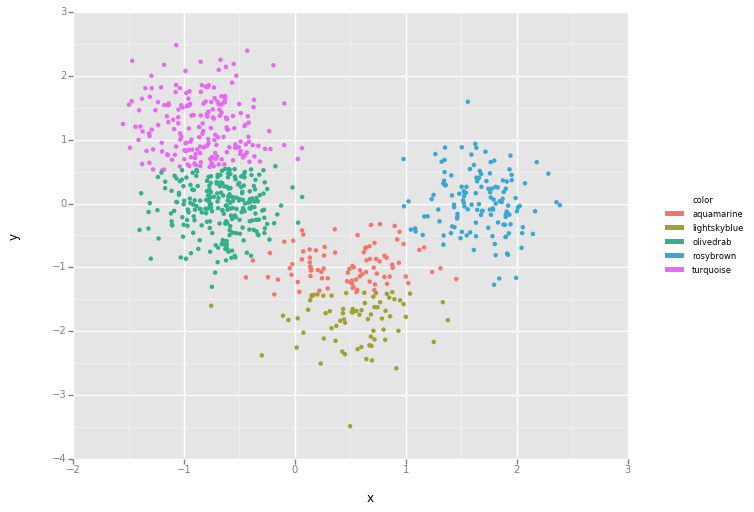

<ggplot: (293692564)>

In [48]:
y_pred = kmeans.y
dat = {'x': X_train.T[0], 'y': X_train.T[1], 'variable': y_pred}
dat = pd.DataFrame (dat)
colors = dict(zip(np.arange(n_centers),list(clrs.cnames.keys())[:n_centers]))
dat['color'] = [colors[variable] for variable in dat['variable']]
ggplot (dat, aes (x = 'x', y = 'y', group = 'variable', color = 'color')) + geom_point ()

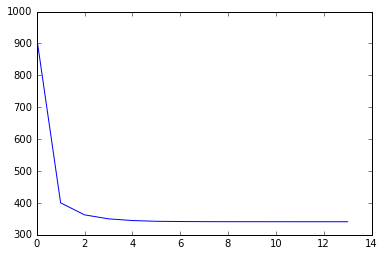

In [49]:
plt.plot(kmeans.cost);

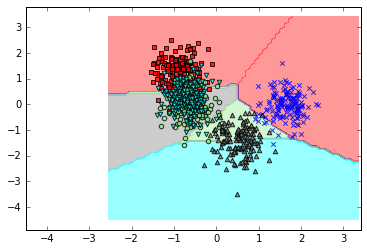

In [50]:
plot_decision_regions(X_train, y_train, kmeans, resolution=0.1)

### Try another "blobs" with different variances

In [52]:
n = 1000
xi1 = np.random.normal(1, 1, (n, 2))
xi2 = np.random.normal(10, 5, (n, 2))
y1 =[0] * n
y2 =[1] * n
X = np.vstack ((xi1, xi2))
y = np.hstack ((y1, y2))

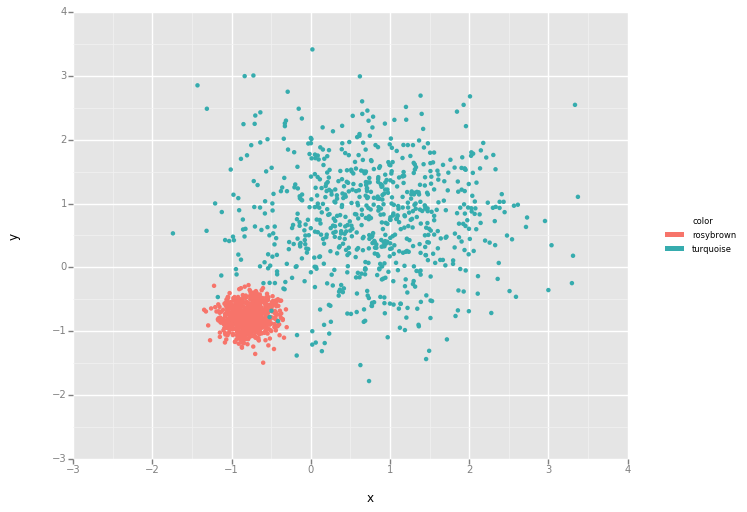

<ggplot: (-9223372036565264268)>

In [54]:
X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
dat = {'x': X_train.T[0], 'y': X_train.T[1], 'variable': y_train}
dat = pd.DataFrame(dat)
colors = dict(zip(np.arange(n_centers),list(clrs.cnames.keys())[:n_centers]))
dat['color'] = [colors[variable] for variable in dat['variable']]
ggplot(aes(x='x', y='y', group='variable',color='color'),dat) + geom_point()

In [55]:
kmeans = KMeans(n_components=2)
kmeans.fit(X_train, n_iter=100);

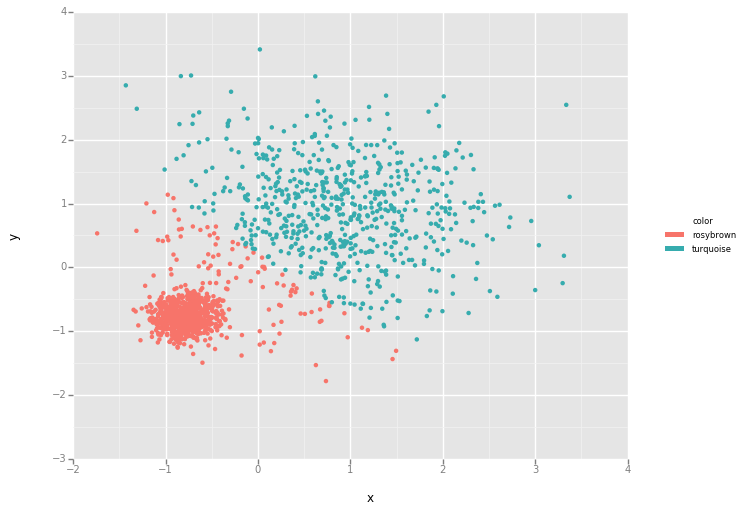

<ggplot: (-9223372036560114807)>

In [56]:
y_pred = kmeans.y
dat = {'x': X_train.T[0], 'y': X_train.T[1], 'variable': y_pred}
dat = pd.DataFrame (dat)
colors = dict(zip(np.arange(n_centers),list(clrs.cnames.keys())[:n_centers]))
dat['color'] = [colors[variable] for variable in dat['variable']]
ggplot (dat, aes (x = 'x', y = 'y', group = 'variable', color = 'color')) + geom_point ()

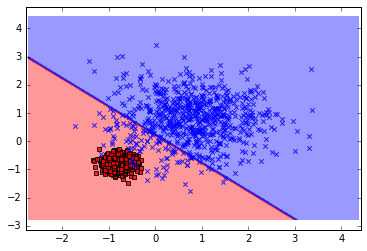

In [57]:
plot_decision_regions(X_train, y_train, kmeans, resolution=0.1)

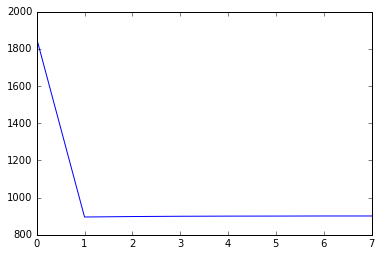

In [58]:
plt.plot(kmeans.cost);

### K-Means with Mahalanobis metric

After convergence of K-Means algorithm make an additional step: update encoder.

**Step 3.** For optimized cluster means $\{\hat{\mu}_j\}_{j=1}^K$ optimize encoder:
$\displaystyle{\underset{1\leq j \leq K}{\mathrm{argmin}}(\x_i-\hat{\mu}_j)\C_j^{-1}(\x_i-\hat{\mu}_j)^T}$, where $\C_j$ - $j$-th cluster covariance matrix.

In [59]:
def mahalanobis_distances(x, mu, cov):
    labs = np.arange(np.array(mu).shape[0])
    return np.array([mahalanobis(x,mu[lab],np.linalg.inv(cov[lab])) for lab in labs])

In [61]:
class KMeansMahalanobis(object):
    
    def __init__(self, n_components = 2, epsilon=0.1):
        self.n_components = n_components
        self.mu = []
        self.cov = []
        self.epsilon = epsilon
        
    def _get_random_point(self, empty_clusters, X, y):
        for cluster in empty_clusters:
            idx = np.random.choice(X.shape[0], 1)[0]
            self.y[idx] = cluster    
    
    def get_cluster_means(self, X, y):
        labs = np.arange(self.n_components)
        mu = [np.mean(X[np.where(y==lab)],axis=0) for lab in labs]
        cov = [np.cov(X[np.where(y==lab)],rowvar=False,ddof=1) for lab in labs]
        return mu, cov
    
    def update_encoder(self, X, mu, cov):
        if self.warm_up:
            y_ = [np.argmin(euclidean_distances(x.reshape(1, -1), mu)) for x in X]
        else:
            y_ = [np.argmin(mahalanobis_distances(x.reshape(1, -1), mu, cov)) for x in X]
        return y_
        
    def within_class_cov(self):
        return np.array(self.cov).sum(axis=0)
    
    def between_class_cov(self):
        return np.cov(np.array(self.mu), rowvar=False)
    
    def get_fisher_discriminant(self):
        Cw = self.within_class_cov()
        Cb = self.between_class_cov()
        A = np.dot(np.linalg.inv(Cw), Cb)
        w, v = np.linalg.eigh(A)
        return v
    
    def fit(self, X, y=None, n_iter=1):
        labs = np.arange(self.n_components)
        n = X.shape[0]
        self.y = np.random.choice(self.n_components, n)
        self.cost_ = []
        self.warm_up = True
        for i in range(n_iter):
            share = np.array([np.array(np.where(self.y == lab)).size for lab in labs])
            empty_clusters = np.array(np.where(share == 0))
            if empty_clusters.size > 0:
                self._get_random_point(empty_clusters, X, self.y)
            if self.warm_up:
                self.mu, self.cov = self.get_cluster_means(X, self.y)          
            cost = np.sum([(mahalanobis_distances(x.reshape(1, -1), self.mu, self.cov)).min() for x in X])
            self.cost_.append(cost)
            
            self.w = self.get_fisher_discriminant()
            
            self.y = self.update_encoder(X, self.mu, self.cov)
            if i > 1 and np.abs(self.cost_[-1] - self.cost_[-2]) < self.epsilon:
                if self.warm_up:
                    self.warm_up = False
                else:
                    break;
        self.y = np.array(self.y)
        return self
    
    def predict(self, X):
        return np.array(self.update_encoder(X, self.mu, self.cov))
    
    def cost(self):
        return np.array(self.cost_)

In [62]:
n = 1000
xi1 = np.random.normal(1, 1, (n, 2))
xi2 = np.random.normal(10, 5, (n, 2))
y1 =[0] * n
y2 =[1] * n
X = np.vstack ((xi1, xi2))
y = np.hstack ((y1, y2))

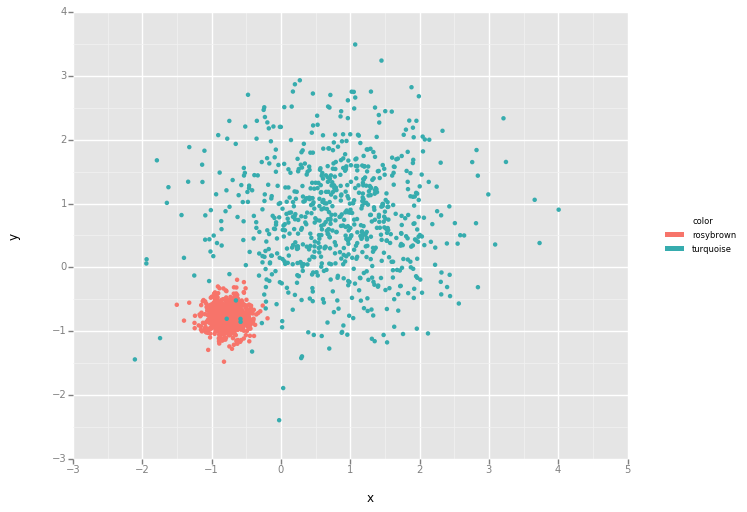

<ggplot: (293189966)>

In [63]:
X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
dat = {'x': X_train.T[0], 'y': X_train.T[1], 'variable': y_train}
dat = pd.DataFrame(dat)
colors = dict(zip(np.arange(n_centers),list(clrs.cnames.keys())[:n_centers]))
dat['color'] = [colors[variable] for variable in dat['variable']]
ggplot(aes(x='x', y='y', group='variable',color='color'),dat) + geom_point()

In [64]:
kmeans = KMeansMahalanobis(n_components=2)
kmeans.fit(X_train, n_iter=100);

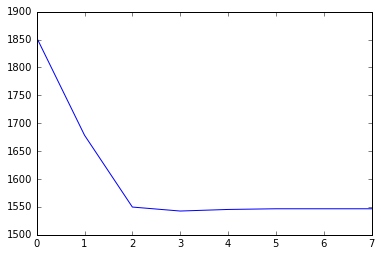

In [65]:
plt.plot(kmeans.cost());

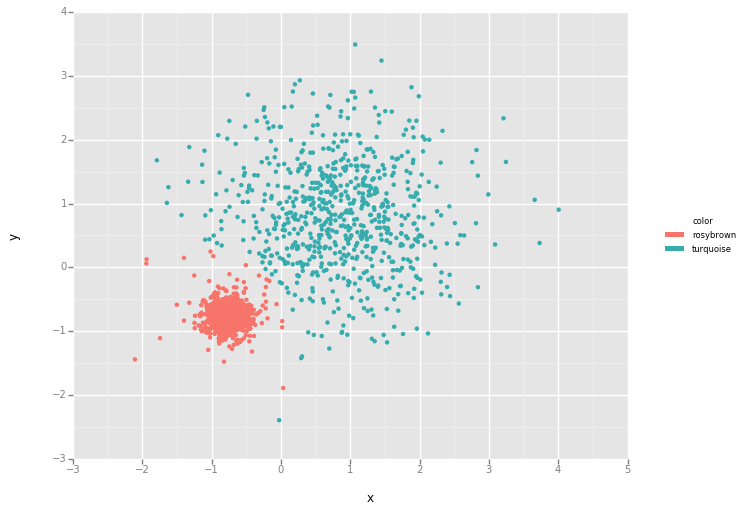

<ggplot: (293192659)>

In [66]:
y_pred = kmeans.y
dat = {'x': X_train.T[0], 'y': X_train.T[1], 'variable': y_pred}
dat = pd.DataFrame (dat)
colors = dict(zip(np.arange(n_centers),list(clrs.cnames.keys())[:n_centers]))
dat['color'] = [colors[variable] for variable in dat['variable']]
ggplot (dat, aes (x = 'x', y = 'y', group = 'variable', color = 'color')) + geom_point ()

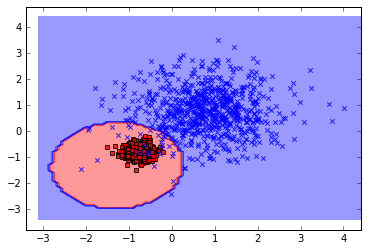

In [67]:
plot_decision_regions(X_train, y_train, kmeans, resolution=0.1)

### Fisher's Linear Discriminant

Let's show, that the cost function of K-Means algorithm:
$$\displaystyle{J(C)=\sum_{j=1}^K\sum_{C(i)=j}\|\x_i-\hat{\mu}_j\|^2}$$
is the trace of within-class covariance matrix.

* Consider the variable $\y=\w^T\x$, where $\x$ is taken from one of two classes $\mathcal{C}_1$ and $\mathcal{C}_2$, which are characterized by mean vectors $\mu_1$ and $\mu_2$. $\w$ is a vector of free parameters.
* Define the Fisher criteria for discriminating between this two classes: $$\displaystyle{J(\w)=\frac{\w^T\C_b\w}{\w^T\C_w\w}}$$
* $\C_b$ is the between-class covariance matrix $$\C_b=\left(\mu_2-\mu_1\right)\left(\mu_2-\mu_1\right)^T$$
* $\C_w$ is the within-class covariance matrix $$\displaystyle{\C_w=\sum_{i\in\mathcal{C}_1}\left(\x_i-\mu_1\right)\left(\x_i-\mu_1\right)^T+\sum_{i\in\mathcal{C}_2}\left(\x_i-\mu_2\right)\left(\x_i-\mu_2\right)^T}$$
* Generalized Rayleigh quotient: the vector $\w$, that maximizes $J(\w)$ must satisfy the condition $$\displaystyle{\C_b\w=\lambda\C_w\w,}$$ where $\lambda$ stands for a scaling factor.
* Transform the last eigenvector-eigenvalue equation to the form $\mathbf{A}\w=\lambda\w$, where $\mathbf{A}=\C_w^{-1}\C_b$, $\lambda$ - eigenvalues, $\w$ - eigenvectors.

In [69]:
class KMeansMahalanobis(object):
    
    def __init__(self, n_components = 2, epsilon=0.1):
        self.n_components = n_components
        self.mu = []
        self.cov = []
        self.epsilon = epsilon
        
    def _get_random_point(self, empty_clusters, X, y):
        for cluster in empty_clusters:
            idx = np.random.choice(X.shape[0], 1)[0]
            self.y[idx] = cluster    
    
    def get_cluster_means(self, X, y):
        labs = np.arange(self.n_components)
        mu = [np.mean(X[np.where(y==lab)],axis=0) for lab in labs]
        cov = [np.cov(X[np.where(y==lab)],rowvar=False,ddof=1) for lab in labs]
        return mu, cov
    
    def update_encoder(self, X, mu, cov):
        if self.warm_up:
            y_ = [np.argmin(euclidean_distances(x.reshape(1, -1), mu)) for x in X]
        else:
            y_ = [np.argmin(mahalanobis_distances(x.reshape(1, -1), mu, cov)) for x in X]
        return y_
        
    def within_class_cov(self):
        return np.array(self.cov).sum(axis=0)
    
    def between_class_cov(self):
        return np.cov(np.array(self.mu), rowvar=False)
    
    def get_fisher_discriminant(self):
        Cw = self.within_class_cov()
        Cb = self.between_class_cov()
        A = np.dot(np.linalg.inv(Cw), Cb)
        w, v = np.linalg.eigh(A)
        self.eig_val = w
        return v
    
    def fit(self, X, y=None, n_iter=1):
        labs = np.arange(self.n_components)
        n = X.shape[0]
        self.y = np.random.choice(self.n_components, n)
        self.cost_ = []
        self.warm_up = True
        for i in range(n_iter):
            share = np.array([np.array(np.where(self.y == lab)).size for lab in labs])
            self.share = share
            empty_clusters = np.array(np.where(share == 0))
            if empty_clusters.size > 0:
                self._get_random_point(empty_clusters, X, self.y)
            if self.warm_up:
                self.mu, self.cov = self.get_cluster_means(X, self.y)          
            cost = np.sum([(mahalanobis_distances(x.reshape(1, -1), self.mu, self.cov)).min() for x in X])
            self.cost_.append(cost)
            
            self.w = self.get_fisher_discriminant()
            
            self.y = self.update_encoder(X, self.mu, self.cov)
            if i > 1 and np.abs(self.cost_[-1] - self.cost_[-2]) < self.epsilon:
                if self.warm_up:
                    self.warm_up = False
                else:
                    break;
        self.y = np.array(self.y)
        
    
    def predict(self, X):
        return np.array(self.update_encoder(X, self.mu, self.cov))
    
    def cost(self):
        return np.array(self.cost_)

In [70]:
kmeans = KMeansMahalanobis(n_components=2)
kmeans.fit(X_train,n_iter=100)

Consider the most informative data projection

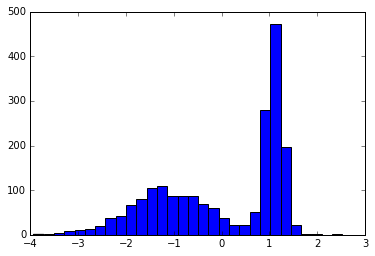

In [74]:
plt.hist(np.dot(X, kmeans.w[1]), bins=30);

In [75]:
print('Eigen-values: ',kmeans.eig_val)

Eigen-values:  [ 0.04152317  4.5465986 ]


Let's plot projected data.

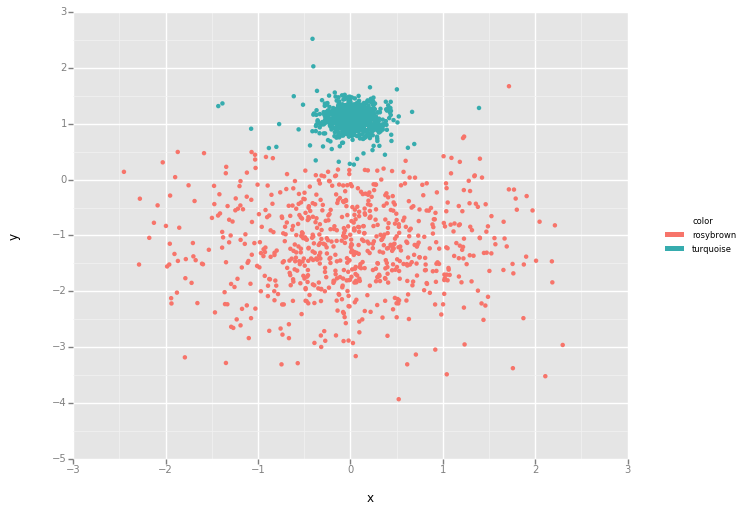

<ggplot: (-9223372036559766503)>

In [76]:
y_pred = kmeans.y

X_proj = np.dot(X_train, kmeans.w)

dat = {'x': X_proj.T[0], 'y': X_proj.T[1], 'variable': y_pred}
dat = pd.DataFrame (dat)
colors = dict(zip(np.arange(n_centers),list(clrs.cnames.keys())[:n_centers]))
dat['color'] = [colors[variable] for variable in dat['variable']]
ggplot (dat, aes (x = 'x', y = 'y', group = 'variable', color = 'color')) + geom_point ()

One can see, that the data were rotated for better distinguishing.

### Determine the number of clusters: elbow method

In [77]:
n_centers = 5

In [78]:
np.random.seed(223458)
X, y = make_blobs(n_samples=1000, centers=n_centers, cluster_std=1.5)

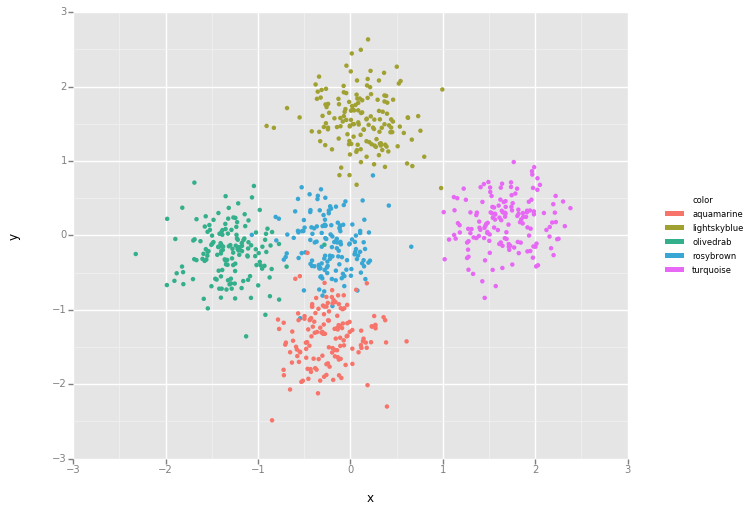

<ggplot: (-9223372036560487943)>

In [79]:
X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
dat = {'x': X_train.T[0], 'y': X_train.T[1], 'variable': y_train}
dat = pd.DataFrame(dat)
colors = dict(zip(np.arange(n_centers),list(clrs.cnames.keys())[:n_centers]))
dat['color'] = [colors[variable] for variable in dat['variable']]
ggplot(aes(x='x', y='y', group='variable',color='color'),dat) + geom_point()

In [80]:
components = np.linspace(2, 10, 9)
cost = []
for n_components in components:
    print(n_components)
    kmeans = KMeans(n_components=int(n_components))
    kmeans.fit(X_train,n_iter=100)
    cost.append(kmeans.cost[-1])
cost = np.array(cost)

2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


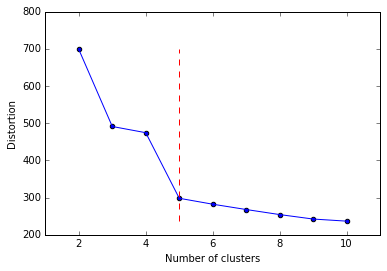

In [81]:
plt.scatter(components, cost)
plt.plot(components, cost)
plt.vlines(x=n_centers, ymin=np.min(cost),ymax=np.max(cost),linestyles='dashed',color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion');

**Elbow method:** going from right to left, take the number of clusters, after which distrotion (within-class-variance) goes up steeply.